# Unconstrained optimization examples

## Quasi-newton methods using BFGS
Consider the problem 

\begin{equation*}
	\begin{aligned}
		& \underset{x_1,x_2}{\text{minimize}}
		& & f(x_1,x_2) = \left(1 - x_{1}\right)^{2} + \left(1 - x_{2}\right)^{2} + \frac{\left(- x_{1}^{2} + 2 x_{2}\right)^{2}}{2}\\
	\end{aligned}
\end{equation*}

having a gradient $$ \nabla f(\mathbf{x}) = \left[\begin{matrix}- 2 x_{1} \left(- x_{1}^{2} + 2 x_{2}\right) + 2 x_{1} - 2\\- 2 x_{1}^{2} + 6 x_{2} - 2\end{matrix}\right]$$ and a Hessian

$$\nabla^2f(\mathbf{x}) = H(\mathbf{x}) = \left[\begin{matrix}6 x_{1}^{2} - 4 x_{2} + 2 & - 4 x_{1}\\- 4 x_{1} & 6\end{matrix}\right]$$


and an optimal solution $\mathbf{x}_0 = (1.21,0.824)$

We define the function `f`, its gradient `grad_f`, and Hessian `H_f` using the below inline functions 


In [16]:
import numpy as np

f = lambda x: ((1 - x[0,:] )**2) + ((1 - x[1,:] )**2) + 0.5*((2*x[1,:] - x[0,:]**2)**2)
grad_f = lambda x: np.array([[2*x[0,:]*(x[0,:]**2 - 2*x[1,:]) + 2*x[0,:] - 2], [-2*x[0,:]**2 + 6*x[1,:] - 2]])
H_f = lambda x: np.array([[list(6*x[0,:]**2 - 4*x[1,:] + 2), list(-4*x[0,:])], [list(-4*x[0,:]), 6*np.ones(x.shape[1])]])

In [17]:
import matplotlib.pyplot as plt
from matplotlib import cm

X1,X2 = np.meshgrid(np.linspace(-3,3,40),np.linspace(-2,5,40))
X = np.vstack((X1.reshape([1,-1]),X2.reshape([1,-1]))) # flatten grids side-by-side

Z = f(X)
Z_grad = grad_f(X)

Let us choose a starting point 
$$\mathbf{x}_0 = \left(-1.0,2.0\right)$$
This gives a steepest descent direction 
$$\mathbf{d}_0^\mathrm{steepest}=-\nabla f(\mathbf{x}_0) = \begin{bmatrix}-2 & -8\end{bmatrix}^\mathrm{T}$$
The direction provided by the inverse of the Hessian is:
$$\mathbf{d}_0=-H^{-1}(\mathbf{x}_0)\nabla f(\mathbf{x}_0) = \left[\begin{matrix}- \frac{3}{8} & \frac{1}{4}\\\frac{1}{4} & 0\end{matrix}\right]\begin{bmatrix}-2 \\ -8\end{bmatrix} = \left[\begin{matrix}- \frac{5}{4} \\- \frac{1}{2}\end{matrix}\right]$$

We can see that the direction provided by Newton's method is not the same as that provided by steepest decent

Let us consider the BFGS method for approximating the inverse of the Hessian instead of calculating it directly. We use the script in [gradient_descent.py](gradient_descent.py) to perform gradient descent iterations.

The choice of direction determines $\mathbf{d}_k$ shown in cyan below. We also show the steepest decent and newton directions using blue and green arrows, respectively.

**A note on BFGS:**

Instead of approximating the Hessian as explained in the lecture, it is possible to approximate its inverse $\hat{B}_k = \hat{H}^{-1}_k$ directly to avoid inverting the Hessian when finding $\mathbf{d}_k = -\hat{H}^{-1}_k\nabla f(\mathbf{x}_k)$ as follows:

$\mathbf {y} _{k}={\nabla f(\mathbf {x} _{k+1})-\nabla f(\mathbf {x} _{k})}$

$\mathbf {s} _{k}=-\alpha _{k}B_{k}\nabla f(\mathbf {x} _{k})$

$\hat{B}_{k+1}=\hat{B}_{k}+{\dfrac {(\mathbf {s} _{k}^{\mathrm {T} }\mathbf {y} _{k}+\mathbf {y} _{k}^{\mathrm {T} }B_{k}\mathbf {y} _{k})(\mathbf {s} _{k}\mathbf {s} _{k}^{\mathrm {T} })}{(\mathbf {s} _{k}^{\mathrm {T} }\mathbf {y} _{k})^{2}}}-{\dfrac {B_{k}\mathbf {y} _{k}\mathbf {s} _{k}^{\mathrm {T} }+\mathbf {s} _{k}\mathbf {y} _{k}^{\mathrm {T} }B_{k}}{\mathbf {s} _{k}^{\mathrm {T} }\mathbf {y} _{k}}}$


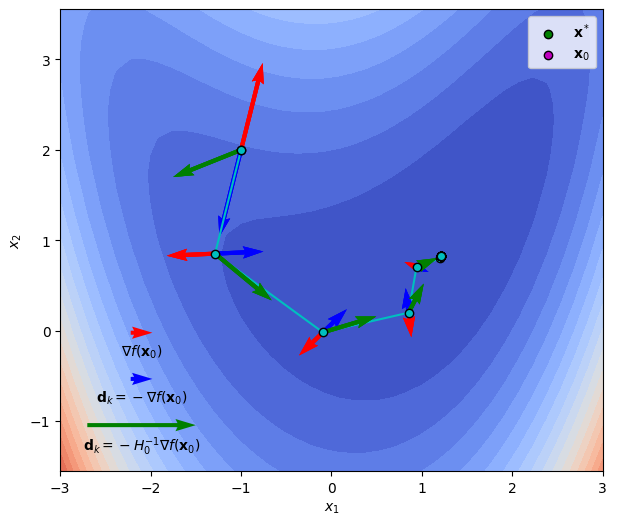

In [18]:
from gradient_descent import GradientDesc

x0 = np.array([-1.0,2.0])
x_opt = [1.2134116627622296, 0.8241226211091329]

solver = GradientDesc(f,grad_f,H_f,x0[:,None],epsilon=0.1,beta=0.9,alpha=0.05,
    direction="newton",line_search="armijo",hessian_approximation="BFGS",verbose=False)

origin = np.array([solver.xk.squeeze()]*3).T # origin point
vectors = np.array([solver.grad_fk.squeeze(), -solver.grad_fk.squeeze(), -(np.linalg.pinv(solver.Hk) @ solver.grad_fk).squeeze()])
# initialize figure
fig, ax = plt.subplots(figsize=(7,6))
# plot
ax.contourf(X1, X2, Z.reshape(X1.shape),cmap=cm.coolwarm,levels=25,zorder=-1)
Q = ax.quiver(*origin, vectors[0:1,0], vectors[0:1,1], color=['r',], scale=50, zorder=1)
ax.quiverkey(Q, 0.15, 0.3, 2, r"$\nabla f(\mathbf{x}_0)$", labelpos='S', coordinates='axes')
Q = ax.quiver(*origin, vectors[1:2,0], vectors[1:2,1], color=['b'], scale=50, zorder=1)
ax.quiverkey(Q, 0.15, 0.2, 2, r"$\mathbf{d}_k = -\nabla f(\mathbf{x}_0)$", labelpos='S', coordinates='axes')
Q = ax.quiver(*origin, vectors[2:3,0], vectors[2:3,1], color=['g'], scale=10, zorder=1)
ax.quiverkey(Q, 0.15, 0.1, 2, r"$\mathbf{d}_k = -H_0^{-1}\nabla f(\mathbf{x}_0)$", labelpos='S', coordinates='axes')
ax.scatter([x_opt[0],], [x_opt[1],], marker="o", color="g", edgecolors="k", linestyle="None",label="$\mathbf{x}^*$",zorder=3)
ax.scatter([x0[0],], [x0[1],], marker="o", color="m", edgecolors="k", linestyle="None",label="$\mathbf{x}_0$",zorder=3)
ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")
ax.axis('equal')
ax.set_xlim((-3,3))
ax.set_ylim((-1,3))
ax.legend()

norms = []
errors = []
iterations = 20
x = [solver.xk[0]]; y = [solver.xk[1]]
for k in range(iterations):
    norm,error_BFGS = solver.step()
    norms += [norm]
    errors += [error_BFGS]
    x += [solver.xk[0]]; y += [solver.xk[1]]

    if k < 20:
        origin = np.array([solver.xk.squeeze()]*3).T # origin point
        vectors = np.array([solver.grad_fk.squeeze(), -solver.grad_fk.squeeze(), -(np.linalg.pinv(solver.Hk) @ solver.grad_fk).squeeze()])
        Q = ax.quiver(*origin, vectors[0:1,0], vectors[0:1,1], color=['r',], scale=50, zorder=2)
        Q = ax.quiver(*origin, vectors[1:2,0], vectors[1:2,1], color=['b'], scale=50, zorder=2)
        Q = ax.quiver(*origin, vectors[2:3,0], vectors[2:3,1], color=['g'], scale=10, zorder=2)
        fig.canvas.draw()

ax.scatter(x,y, linestyle="None", marker="o", color="c", edgecolors="k",zorder=3)
ax.plot(x,y, linestyle="-", marker="None", color="c", zorder=1);
# fig.savefig("unconstrainted_ex.pdf",bbox_inches="tight")

We also examine the rate at which the algorithm iteration converge by plotting the norm of the gradient $\left|\left|\nabla f(\mathbf{x})\right|\right|$ and the mean squared error in inverse Hessian approximation (if using BFGS and newton's direction)

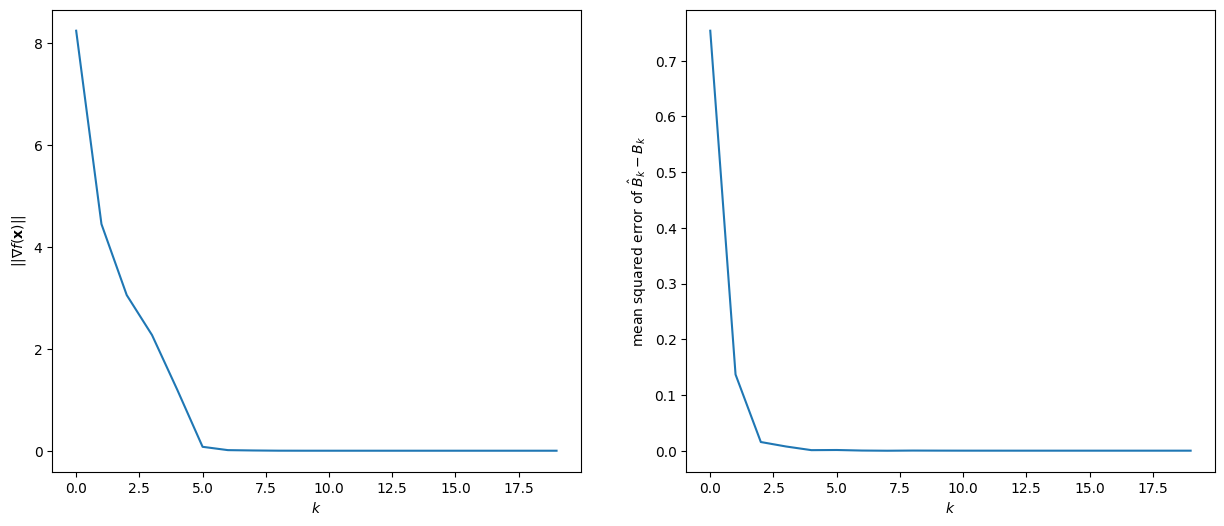

In [19]:
fig, axs = plt.subplots(nrows=1,ncols=2,figsize=(15,6))
axs[0].plot(list(range(iterations)),norms)
axs[0].set_ylabel(r"$||\nabla f(\mathbf{x})||$")
axs[0].set_xlabel(r"$k$")
axs[1].plot(list(range(iterations)),errors)
axs[1].set_ylabel(r"mean squared error of $\hat{B}_k - B_k$")
axs[1].set_xlabel(r"$k$");
# fig, axs = plt.subplots()
# axs.plot(list(range(iterations)),norms)
# axs.set_ylabel(r"$||\nabla f(\mathbf{x})||$")
# axs.set_xlabel(r"$k$")
# fig.savefig("unconstrainted_ex_conv.pdf",bbox_inches="tight")

In addition to newton's method the class ``GradientDesc`` provides several possible optimization algorithms by changing the below arguments.

|`direction`    |`line_search`  |`hessian_approximation`|
|---------------|---------------|-----------------------|
| "steepest"    | "exact"       | "exact"               |
| "newton"      | "armijo"      | "BFGS"                |

Instead of manually looping and calling the ``solver.step()`` method you can directly optimize the objective and get your answer using ``solver.optimize()``

In [20]:
from gradient_descent import GradientDesc

# define initial guess
x0 = np.array([-1.0,2.0])

# define your objective, gradient, and hessian (if applicable)
f = lambda x: ((1 - x[0,:] )**2) + ((1 - x[1,:] )**2) + 0.5*((2*x[1,:] - x[0,:]**2)**2)
grad_f = lambda x: np.array([[2*x[0,:]*(x[0,:]**2 - 2*x[1,:]) + 2*x[0,:] - 2], [-2*x[0,:]**2 + 6*x[1,:] - 2]])
H_f = lambda x: np.array([[list(6*x[0,:]**2 - 4*x[1,:] + 2), list(-4*x[0,:])], [list(-4*x[0,:]), 6*np.ones(x.shape[1])]])

# initialize solver
solver = GradientDesc(f,grad_f,H_f,x0[:,None],epsilon=0.1,beta=0.9,alpha=0.05,
    direction="newton",line_search="armijo",hessian_approximation="BFGS",verbose=False)

k, x_opt, f_opt = solver.optimize(tol=1e-6)

print("the optimizer is: " + ",".join(["{}".format(x) for x in x_opt]))
print("the value of f at the optimizer is: %f" %f_opt)

the optimizer is: [1.21341166],[0.82412264]
the value of f at the optimizer is: 0.091944


## Conjugate gradient algorithm

### Conjugate gradients algorithm applied to Quadratic function

Consider the problem 

\begin{equation*}
	\begin{aligned}
		& \underset{x_1,x_2}{\text{minimize}}
		& & f(x_1,x_2) = 4x_1^2 + 3x_1x_2 + x_2^2\\
	\end{aligned}
\end{equation*}

having a gradient $$ \nabla f(\mathbf{x}) = \begin{bmatrix} 8x_1 + 3x_2 \\ 3x_1 + 2x_2 \end{bmatrix}$$ and a Hessian

$$\nabla^2f(\mathbf{x}) = H(\mathbf{x}) = \left[\begin{matrix}8 & 3\\3 & 2\end{matrix}\right]$$

and an optimal solution $\mathbf{x}^* = (0,0)$

We define the function `f`, its gradient `grad_f`, and Hessian `H_f` using the below inline functions  

In [28]:
f = lambda x: 4*x[0,:]**2 + 3*x[0,:]**1*x[1,:]**1 + x[1,:]**2
grad_f = lambda x: np.array([[8*x[0,:] + 3*x[1,:]], [3*x[0,:] + 2*x[1,:]]])
H_f = lambda x: np.array([[8*np.ones(x.shape[1]), 3*np.ones(x.shape[1])], [3*np.ones(x.shape[1]), 2*np.ones(x.shape[1])]])

We generate a grid of values to visualize the objective function below:

In [29]:
X1,X2 = np.meshgrid(np.linspace(-3,3,40),np.linspace(-3,2,40))
X = np.vstack((X1.reshape([1,-1]),X2.reshape([1,-1]))) # flatten grids side-by-side

Z = f(X)
Z_grad = grad_f(X)

We can see from the trace below, that the conjugate gradients algorithm converged to the exact solution $(0,0)$ in $n=2$ steps!

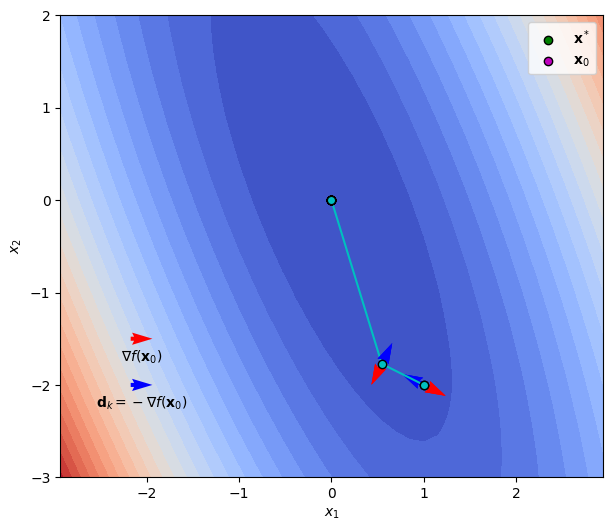

In [35]:
from gradient_descent import ConjugateDesc

x0 = np.array([1.0,-2.0])
x_opt = [0.0, 0.0]

solver = ConjugateDesc(f,grad_f,H_f,x0[:,None],verbose=False)

origin = np.array([solver.xk.squeeze()]*3).T # origin point
vectors = np.array([solver.grad_fk.squeeze(), -solver.grad_fk.squeeze(), -(np.linalg.pinv(solver.Hk) @ solver.grad_fk).squeeze()])
# initialize figure
fig, ax = plt.subplots(figsize=(7,6))
# plot
ax.contourf(X1, X2, Z.reshape(X1.shape),cmap=cm.coolwarm,levels=25,zorder=-1)
Q = ax.quiver(*origin, vectors[0:1,0], vectors[0:1,1], color=['r',], scale=50, zorder=1)
ax.quiverkey(Q, 0.15, 0.3, 2, r"$\nabla f(\mathbf{x}_0)$", labelpos='S', coordinates='axes')
Q = ax.quiver(*origin, vectors[1:2,0], vectors[1:2,1], color=['b'], scale=50, zorder=1)
ax.quiverkey(Q, 0.15, 0.2, 2, r"$\mathbf{d}_k = -\nabla f(\mathbf{x}_0)$", labelpos='S', coordinates='axes')
ax.scatter([x_opt[0],], [x_opt[1],], marker="o", color="g", edgecolors="k", linestyle="None",label="$\mathbf{x}^*$",zorder=3)
ax.scatter([x0[0],], [x0[1],], marker="o", color="m", edgecolors="k", linestyle="None",label="$\mathbf{x}_0$",zorder=3)
ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")
ax.axis('equal')
ax.set_xlim((-2,2))
ax.set_ylim((-3,2))
ax.legend()

norms = []
iterations = 20
x = [solver.xk[0]]; y = [solver.xk[1]]
for k in range(iterations):
    norm = solver.step()
    norms += [norm]
    x += [solver.xk[0]]; y += [solver.xk[1]]

    if k < 20:
        origin = np.array([solver.xk.squeeze()]*3).T # origin point
        vectors = np.array([solver.grad_fk.squeeze(), -solver.grad_fk.squeeze(), -(np.linalg.pinv(solver.Hk) @ solver.grad_fk).squeeze()])
        Q = ax.quiver(*origin, vectors[0:1,0], vectors[0:1,1], color=['r',], scale=50, zorder=2)
        Q = ax.quiver(*origin, vectors[1:2,0], vectors[1:2,1], color=['b'], scale=50, zorder=2)
        fig.canvas.draw()

ax.scatter(x,y, linestyle="None", marker="o", color="c", edgecolors="k",zorder=3)
ax.plot(x,y, linestyle="-", marker="None", color="c", zorder=1);
# fig.savefig("conjugate_gradients.pdf",bbox_inches="tight")

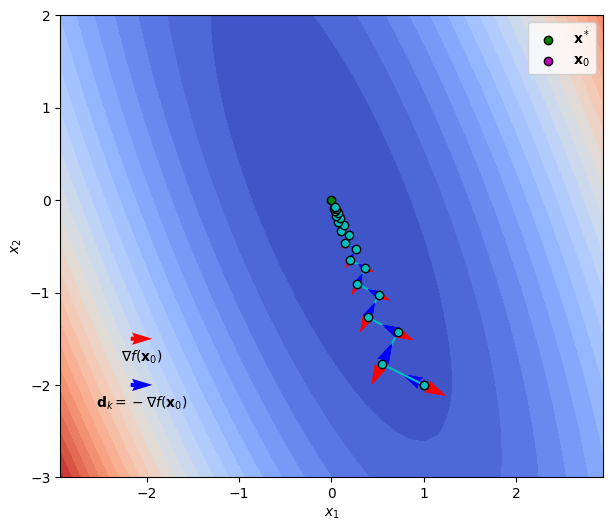

In [36]:
x0 = np.array([1.0,-2.0])
x_opt = [0.0, 0.0]

solver = GradientDesc(f,grad_f,H_f,x0[:,None],direction="steepest",line_search="exact",verbose=False)

origin = np.array([solver.xk.squeeze()]*3).T # origin point
vectors = np.array([solver.grad_fk.squeeze(), -solver.grad_fk.squeeze(), -(np.linalg.pinv(solver.Hk) @ solver.grad_fk).squeeze()])
# initialize figure
fig, ax = plt.subplots(figsize=(7,6))
# plot
ax.contourf(X1, X2, Z.reshape(X1.shape),cmap=cm.coolwarm,levels=25,zorder=-1)
Q = ax.quiver(*origin, vectors[0:1,0], vectors[0:1,1], color=['r',], scale=50, zorder=1)
ax.quiverkey(Q, 0.15, 0.3, 2, r"$\nabla f(\mathbf{x}_0)$", labelpos='S', coordinates='axes')
Q = ax.quiver(*origin, vectors[1:2,0], vectors[1:2,1], color=['b'], scale=50, zorder=1)
ax.quiverkey(Q, 0.15, 0.2, 2, r"$\mathbf{d}_k = -\nabla f(\mathbf{x}_0)$", labelpos='S', coordinates='axes')
ax.scatter([x_opt[0],], [x_opt[1],], marker="o", color="g", edgecolors="k", linestyle="None",label="$\mathbf{x}^*$",zorder=3)
ax.scatter([x0[0],], [x0[1],], marker="o", color="m", edgecolors="k", linestyle="None",label="$\mathbf{x}_0$",zorder=3)
ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")
ax.axis('equal')
ax.set_xlim((-2,2))
ax.set_ylim((-3,2))
ax.legend()

norms = []
iterations = 20
x = [solver.xk[0]]; y = [solver.xk[1]]
for k in range(iterations):
    norm = solver.step()
    norms += [norm]
    x += [solver.xk[0]]; y += [solver.xk[1]]

    if k < 20:
        origin = np.array([solver.xk.squeeze()]*3).T # origin point
        vectors = np.array([solver.grad_fk.squeeze(), -solver.grad_fk.squeeze(), -(np.linalg.pinv(solver.Hk) @ solver.grad_fk).squeeze()])
        Q = ax.quiver(*origin, vectors[0:1,0], vectors[0:1,1], color=['r',], scale=50, zorder=2)
        Q = ax.quiver(*origin, vectors[1:2,0], vectors[1:2,1], color=['b'], scale=50, zorder=2)
        fig.canvas.draw()

ax.scatter(x,y, linestyle="None", marker="o", color="c", edgecolors="k",zorder=3)
ax.plot(x,y, linestyle="-", marker="None", color="c", zorder=1);
# fig.savefig("gradient_descent_Quad.pdf",bbox_inches="tight")

Let us compare the gradient descent algorithm with exact line search and see how many steps are needed by comparison:

### Conjugate gradients algorithm applied to a non-quadratic function

We will now try solving the a non-quadratic problem using the conjugate gradients algorithm:

\begin{equation*}
	\begin{aligned}
		& \underset{x_1,x_2}{\text{minimize}}
		& & f(x_1,x_2) = \left(1 - x_{1}\right)^{2} + \left(1 - x_{2}\right)^{2} + \frac{\left(- x_{1}^{2} + 2 x_{2}\right)^{2}}{2}\\
	\end{aligned}
\end{equation*}

having a gradient $$ \nabla f(\mathbf{x}) = \left[\begin{matrix}- 2 x_{1} \left(- x_{1}^{2} + 2 x_{2}\right) + 2 x_{1} - 2\\- 2 x_{1}^{2} + 6 x_{2} - 2\end{matrix}\right]$$ and a Hessian

$$\nabla^2f(\mathbf{x}) = H(\mathbf{x}) = \left[\begin{matrix}6 x_{1}^{2} - 4 x_{2} + 2 & - 4 x_{1}\\- 4 x_{1} & 6\end{matrix}\right]$$

In [25]:
f = lambda x: ((1 - x[0,:] )**2) + ((1 - x[1,:] )**2) + 0.5*((2*x[1,:] - x[0,:]**2)**2)
grad_f = lambda x: np.array([[2*x[0,:]*(x[0,:]**2 - 2*x[1,:]) + 2*x[0,:] - 2], [-2*x[0,:]**2 + 6*x[1,:] - 2]])
H_f = lambda x: np.array([[list(6*x[0,:]**2 - 4*x[1,:] + 2), list(-4*x[0,:])], [list(-4*x[0,:]), 6*np.ones(x.shape[1])]])

We generate a grid of values to visualize the objective function below:

In [26]:
X1,X2 = np.meshgrid(np.linspace(-3,3,40),np.linspace(-2,5,40))
X = np.vstack((X1.reshape([1,-1]),X2.reshape([1,-1]))) # flatten grids side-by-side

Z = f(X)
Z_grad = grad_f(X)

We can see from the trace below, that the conjugate gradients algorithm required more than $n=2$ steps to converge since $f(\mathbf{x})$ is no longer quadratic

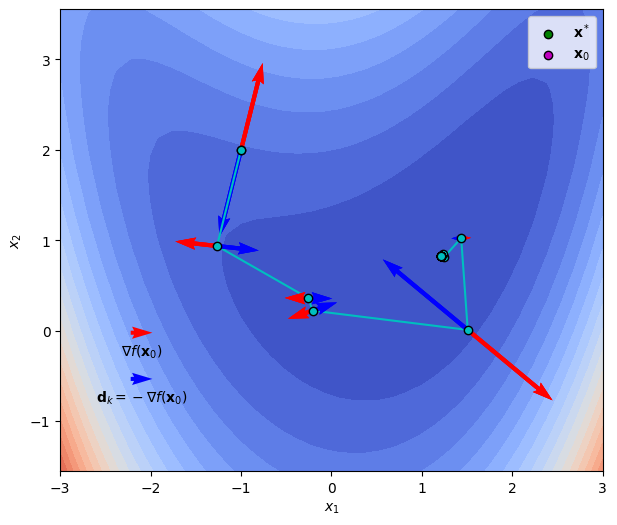

In [27]:
x0 = np.array([-1.0,2.0])
x_opt = [1.2134116627622296, 0.8241226211091329]

solver = ConjugateDesc(f,grad_f,H_f,x0[:,None],verbose=False)

origin = np.array([solver.xk.squeeze()]*3).T # origin point
vectors = np.array([solver.grad_fk.squeeze(), -solver.grad_fk.squeeze(), -(np.linalg.pinv(solver.Hk) @ solver.grad_fk).squeeze()])
# initialize figure
fig, ax = plt.subplots(figsize=(7,6))
# plot
ax.contourf(X1, X2, Z.reshape(X1.shape),cmap=cm.coolwarm,levels=25,zorder=-1)
Q = ax.quiver(*origin, vectors[0:1,0], vectors[0:1,1], color=['r',], scale=50, zorder=1)
ax.quiverkey(Q, 0.15, 0.3, 2, r"$\nabla f(\mathbf{x}_0)$", labelpos='S', coordinates='axes')
Q = ax.quiver(*origin, vectors[1:2,0], vectors[1:2,1], color=['b'], scale=50, zorder=1)
ax.quiverkey(Q, 0.15, 0.2, 2, r"$\mathbf{d}_k = -\nabla f(\mathbf{x}_0)$", labelpos='S', coordinates='axes')
ax.scatter([x_opt[0],], [x_opt[1],], marker="o", color="g", edgecolors="k", linestyle="None",label="$\mathbf{x}^*$",zorder=3)
ax.scatter([x0[0],], [x0[1],], marker="o", color="m", edgecolors="k", linestyle="None",label="$\mathbf{x}_0$",zorder=3)
ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")
ax.axis('equal')
ax.set_xlim((-3,3))
ax.set_ylim((-1,3))
ax.legend()

norms = []
iterations = 20
x = [solver.xk[0]]; y = [solver.xk[1]]
for k in range(iterations):
    norm = solver.step()
    norms += [norm]
    x += [solver.xk[0]]; y += [solver.xk[1]]

    if k < 20:
        origin = np.array([solver.xk.squeeze()]*3).T # origin point
        vectors = np.array([solver.grad_fk.squeeze(), -solver.grad_fk.squeeze(), -(np.linalg.pinv(solver.Hk) @ solver.grad_fk).squeeze()])
        Q = ax.quiver(*origin, vectors[0:1,0], vectors[0:1,1], color=['r',], scale=50, zorder=2)
        Q = ax.quiver(*origin, vectors[1:2,0], vectors[1:2,1], color=['b'], scale=50, zorder=2)
        fig.canvas.draw()

ax.scatter(x,y, linestyle="None", marker="o", color="c", edgecolors="k",zorder=3)
ax.plot(x,y, linestyle="-", marker="None", color="c", zorder=1);